In [2]:
from PIL import Image
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt

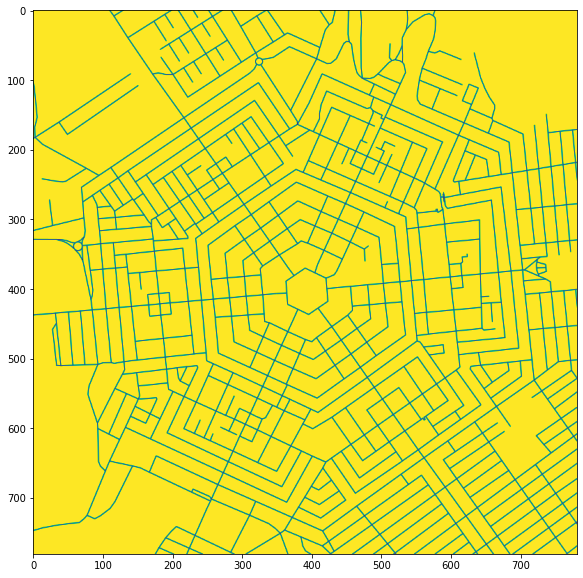

In [23]:
# image = Image.open("San Francisco.png")
# image = Image.open("la plata.png")
image = Image.open("grammichele.png")
image = image.convert('L')
# image = np.logical_not(np.array(image))
# image = image[1000:2300,3200:4500]
# print(image.shape)
fig = plt.figure(facecolor='w', figsize=(10,10))
plt.imshow(image)
plt.show()

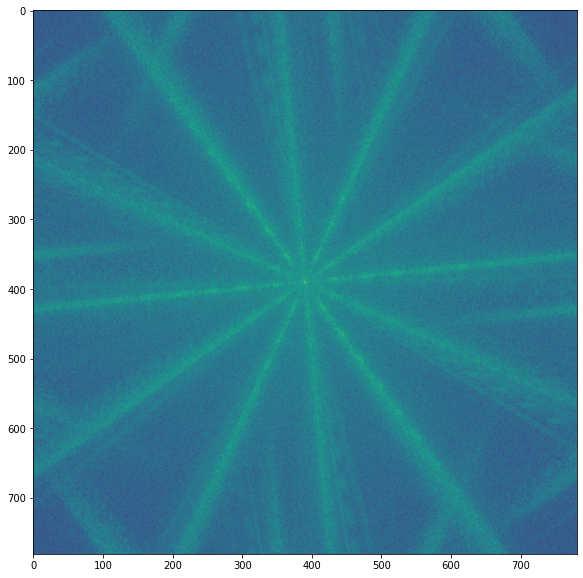

In [24]:
image = np.array(image)
im_fft = np.fft.fft2(image)
im_fft = np.fft.fftshift(im_fft)
im_fft = np.abs(im_fft)
# im_fft = np.log(im_fft)
# Image.fromarray(im_fft, 'L')
fig = plt.figure(facecolor='w', figsize=(10,10))
plt.imshow(np.log(im_fft))
plt.show()

In [4]:
im_fft.shape

(1107, 1107)

https://12ft.io/proxy?q=https%3A%2F%2Flevelup.gitconnected.com%2Fa-simple-method-to-calculate-circular-intensity-averages-in-images-4186a685af3

In [25]:
img = im_fft
# Image center
cen_x = im_fft.shape[0]//2
cen_y = cen_x
# Get image parameters
a = img.shape[0]
b = img.shape[1]
# Find radial distances
[X, Y] = np.meshgrid(np.arange(b) - cen_x, np.arange(a) - cen_y)
R = np.sqrt(np.square(X) + np.square(Y))
rad = np.arange(1, np.max(R), 1)
intensity = np.zeros(len(rad))
index = 0
bin_size = 3
for i in rad:
    mask = (np.greater(R, i - bin_size) & np.less(R, i + bin_size))
    values = img[mask]
    intensity[index] = np.mean(values)
    index += 1

(0.0, 600.0)

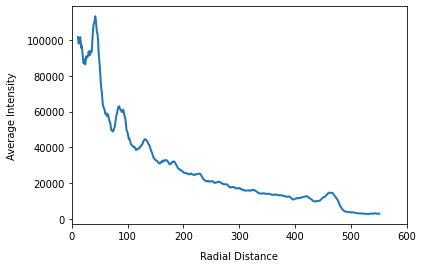

In [26]:
# Create figure and add subplot
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
# Plot data
# log_int = np.log(intensity)
cutoff = 10
ax.plot(rad[cutoff:], intensity[cutoff:], linewidth=2)
# Edit axis labels
ax.set_xlabel('Radial Distance', labelpad=10)
ax.set_ylabel('Average Intensity', labelpad=10)
ax.set_xlim(0,600)
# ax.set_ylim(0,0.07e6)

In [14]:
x = np.arange(0, 90, 90/(len(intensity)))

In [15]:
data = zip(x[cutoff:], intensity[cutoff:])
data = list(data)

In [16]:
import csv

# write csv file
with open('SLC.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ')
    writer.writerows(data)